# STARTING ANALYSIS FOR WINNER PREDICTION  - 26/07/2025 20:07 

In [1]:
# LOADING LIBRARIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# LOADING DATA
df = pd.read_excel("../data/AuctionData.xlsx")

In [3]:
print(df.shape)

(3422, 14)


In [4]:
print(df.head())

                      Catalogue_No Auction_Date          Plant Plant_Code  \
0  IOCL/1500/1583/2021-2022/66/897   2022-02-01  Pattikalan BP       1583   
1  IOCL/1500/1583/2021-2022/66/897   2022-02-01  Pattikalan BP       1583   
2  IOCL/1500/1583/2021-2022/66/897   2022-02-01  Pattikalan BP       1583   
3  IOCL/2100/2172/2021-2022/85/876   2022-02-01   Raninagar BP       2172   
4  IOCL/1200/1272/2021-2022/58/893   2022-02-02       Baddi BP       1272   

   SCode                     State                             H1_Buyer_Name  \
0   1500       Uttar Pradesh SO II  BANSAL ALLOYS AND METALS PRIVATE LIMITED   
1   1500       Uttar Pradesh SO II  BANSAL ALLOYS AND METALS PRIVATE LIMITED   
2   1500       Uttar Pradesh SO II  BANSAL ALLOYS AND METALS PRIVATE LIMITED   
3   2100  West Bengal State Office                        AKSHAT ENTERPRISES   
4   1200       Punjab& Himachal SO  BANSAL ALLOYS AND METALS PRIVATE LIMITED   

   Proposed_RP  Quantity AuctUOM  Last_Bid_Price   total

In [5]:
# CLEANING COLUMN NAMES
df.columns = df.columns.str.lower()
df.columns = df.columns.str.replace(" ", "_")
df.columns = df.columns.str.replace("-", "_")
df.columns = df.columns.str.replace("(", "")
df.columns = df.columns.str.replace(")", "")
df.columns = df.columns.str.replace("/", "_")
df.columns = df.columns.str.replace(":", "_")
df.columns = df.columns.str.replace(".", "_")
df.columns = df.columns.str.replace("!", "")
df.columns = df.columns.str.replace("?", "")
df.columns = df.columns.str.replace("&", "and")

In [6]:
# CHECKING FOR NULL VALUES
df.isnull().sum()

catalogue_no          0
auction_date          0
plant                 0
plant_code            0
scode                 0
state                 0
h1_buyer_name         0
proposed_rp           0
quantity              0
auctuom               0
last_bid_price        0
total_amt             0
material_code         0
productdescription    0
dtype: int64

### TARGET VARIABLE ANALYSIS

In [7]:
#counting the number of unqiue buyers
print(df['h1_buyer_name'].nunique())

271


In [8]:
#buyer auction wins distribution
buyer_wins_count= df.groupby('h1_buyer_name').size().reset_index(name = 'wins')
print(buyer_wins_count.sort_values(by = 'wins', ascending = False))
#checking for unique win counts
print(buyer_wins_count['wins'].nunique())
win_distribution = buyer_wins_count['wins'].value_counts().sort_index()

win_counts = win_distribution.index
buyer_counts = win_distribution.values


                                h1_buyer_name  wins
37   BANSAL ALLOYS AND METALS PRIVATE LIMITED   571
250           True Values Trading Corporation   134
155                       NIRMALA SCRAP HOUSE   131
206                       SGR Trading Company   124
111                         Laxcon Steels Ltd   101
..                                        ...   ...
261                             YAHYA TRADERS     1
266                                k.p.steels     1
264                         ZINIC ENTERPRISES     1
263                             YUVIKA ALLOYS     1
270                             vinay traders     1

[271 rows x 2 columns]
48


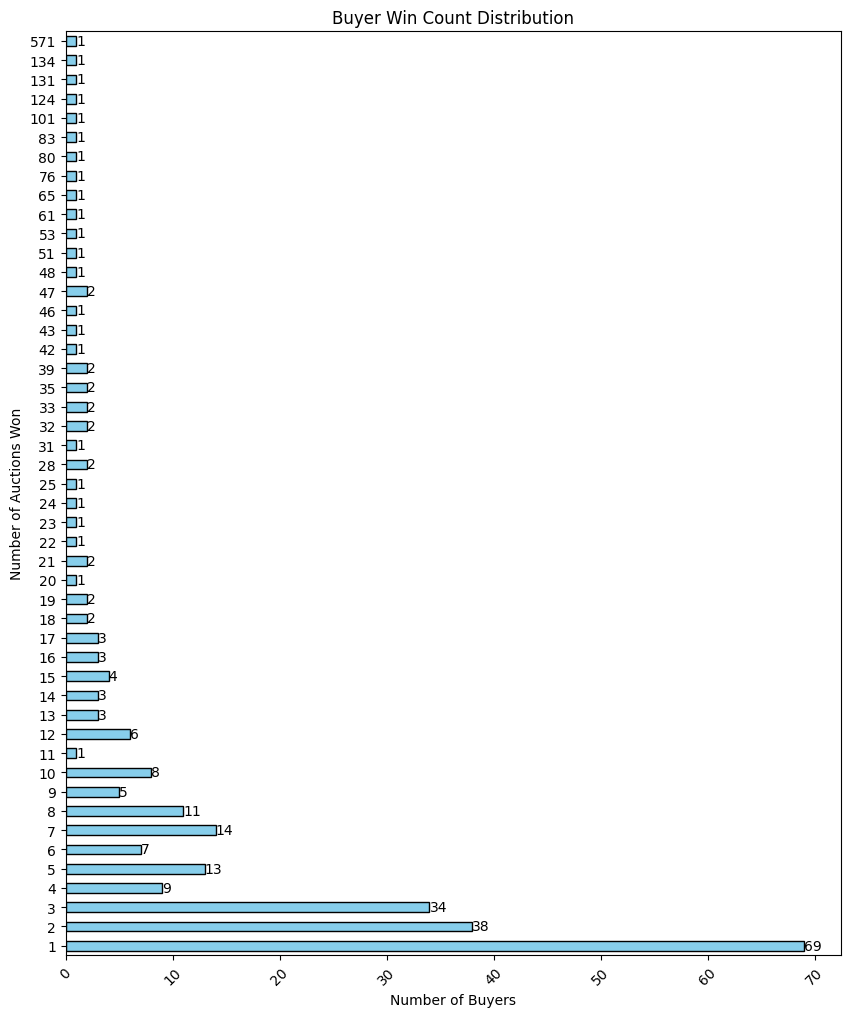

In [9]:
#normalizing win counts for color mapping
# norm = plt.Normalize(win_counts.min(), win_counts.max())
# colors = plt.cm.viridis(norm(win_counts))

plt.figure(figsize=(10,12))
num = win_distribution.plot(kind='barh', color='skyblue', edgecolor='black')
plt.title('Buyer Win Count Distribution')
plt.xlabel('Number of Buyers')
plt.ylabel('Number of Auctions Won')
plt.xticks(rotation=45)
# plt.tight_layout()
for container in num.containers:
    num.bar_label(container, label_type='edge', fontsize=10)
plt.show()

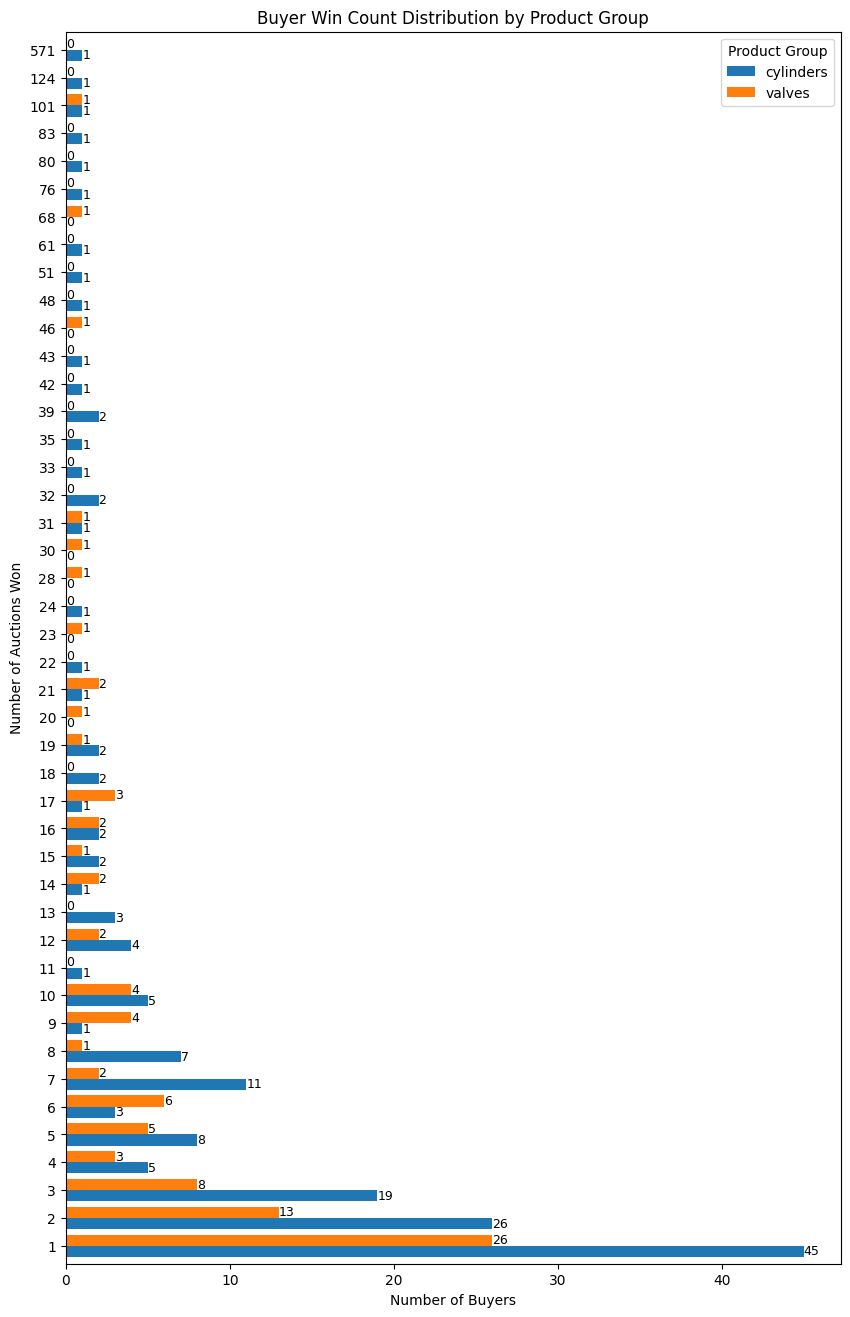

In [10]:
#distributing win distribution as per category
cylinders = [x.lower().strip() for x in [
    '14.2 Kg', '19 Kg', '5 Kg', '47.5 Kg', '5 Kg FTLR', '5 Kg ND',
    '47.5 Kg LOTV', '19 Kg SC', '19 Kg NCut', '5 Kg FTL', '14.2 Kg OMC'
]]
valves = [x.lower().strip() for x in ['SC Valve', 'LIQUID OFFTAKE VALVE']]
def map_product_type(desc):
    desc = str(desc).lower().strip()
    if desc in cylinders:
        return 'cylinders'
    elif desc in valves:
        return 'valves'
    else:
        return 'other'
df['product_group'] = df['productdescription'].apply(map_product_type)
df_filtered = df[df['product_group'].isin(['cylinders', 'valves'])].copy()

win_by_group = df_filtered.groupby(['product_group', 'h1_buyer_name']).size().reset_index(name = 'wins_per_category')

distr = win_by_group.groupby(['product_group', 'wins_per_category']).size().unstack(fill_value = 0)


ax = distr.T.plot(kind='barh', width=0.8, stacked=False, figsize=(10, 16))
plt.ylabel('Number of Auctions Won')
plt.xlabel('Number of Buyers')
plt.title('Buyer Win Count Distribution by Product Group')
plt.legend(title='Product Group')

for container in ax.containers:
    ax.bar_label(container, label_type='edge', fontsize=9)

plt.show()


In [11]:
print(df_filtered.shape)

(3082, 15)


In [12]:
df_filtered['month'] = df_filtered['auction_date'].dt.month

In [13]:
# Categorize buyers by win frequency
buyer_counts = df_filtered['h1_buyer_name'].value_counts()

df_filtered['buyer_category'] = df_filtered['h1_buyer_name'].map(buyer_counts).apply(
    lambda x: 'High_Freq' if x > 100 else ('Mid_Freq' if x > 20 else 'Low_Freq')
)



# Analyze win timing by buyer category
print("=== WIN TIMING BY BUYER CATEGORY ===")
for category in ['High_Freq', 'Mid_Freq', 'Low_Freq']:
    category_data = df_filtered[df_filtered['buyer_category'] == category]
    print(f"\n{category} buyers:")
    print(f"Total winners: {category_data['h1_buyer_name'].nunique()}")
    print(f"Date range: {category_data['auction_date'].min()} to {category_data['auction_date'].max()}")
    print(f"Most active month: {category_data['month'].mode().iloc[0]}")


=== WIN TIMING BY BUYER CATEGORY ===

High_Freq buyers:
Total winners: 4
Date range: 2022-02-01 00:00:00 to 2025-06-19 00:00:00
Most active month: 8

Mid_Freq buyers:
Total winners: 25
Date range: 2022-02-01 00:00:00 to 2025-06-13 00:00:00
Most active month: 2

Low_Freq buyers:
Total winners: 225
Date range: 2022-02-02 00:00:00 to 2025-06-12 00:00:00
Most active month: 2


In [14]:
#Extracting win dates for buyers with <19 wins
low_freq_buyers = buyer_counts[buyer_counts < 19].index
df_low_freq = df_filtered[df_filtered['h1_buyer_name'].isin(low_freq_buyers)].copy()
df_low_freq['total_wins'] = df_low_freq['h1_buyer_name'].map(buyer_counts)
df_low_freq[['h1_buyer_name', 'auction_date']].sort_values(by='auction_date').to_excel(
    'low_freq_win_dates.xlsx', index=False
)


In [15]:
df_low_freq.drop(columns = ['buyer_category'], inplace = True)


In [16]:
df_low_freq.head(10)


,catalogue_no,auction_date,plant,plant_code,scode,state,h1_buyer_name,proposed_rp,quantity,auctuom,last_bid_price,total_amt,material_code,productdescription,product_group,month,total_wins
8,IOCL/2300/2377/2021-2022/49/882,2022-02-02,Banka BP,2377,2300,Bihar State Office,RAMOJI METALS,459000.00,9.432,MT,471000,5294539.0,838881064,SC Valve,valves,2,9
10,IOCL/2100/2173/2021-2022/74/735,2022-02-03,Kalyani BP,2173,2100,West Bengal State Office,ASHISH SHIPBREAKERS PRIVATE LIMITED,448333.33,18.050,MT,460000,9895516.0,838881064,SC Valve,valves,2,9
11,IOCL/4200/4271/2021-2022/59/925,2022-02-03,Quilon BP,4271,4200,Kerala State Office,THIEHINGOTS PVT LTD,35166.67,66.500,MT,39000,3090934.0,838903004,19 Kg,cylinders,2,3
14,IOCL/2200/2272/2021-2022/31/904,2022-02-04,Jharsuguda BP,2272,2200,Odisha State Office,Jain Brothers,448666.67,10.620,MT,475000,6012036.0,838881064,SC Valve,valves,2,1
18,IOCL/1500/1572/2021-2022/60/794,2022-02-07,Mathura BP,1572,1500,Uttar Pradesh SO II,GAGAN ENTERPRISES,447333.33,11.194,MT,477000,6363662.0,838881064,SC Valve,valves,2,14
19,IOCL/2100/2171/2021-2022/89/926,2022-02-07,Durgapur BP,2171,2100,West Bengal State Office,NEELANCHAL ENTERPRISES,461666.67,16.200,MT,469000,9055059.0,838881064,SC Valve,valves,2,3
35,IOCL/2100/2177/2021-2022/93/939,2022-02-10,Malda BP,2177,2100,West Bengal State Office,JUHI TRANSPORT,462000.00,8.010,MT,488000,4658604.0,838881064,SC Valve,valves,2,1
37,IOCL/1400/1473/2021-2022/37/910,2022-02-11,Allahabad BP,1473,1400,Uttar Pradesh SO I,JANKI ENTERPRISES,455000.00,27.000,MT,479000,15413550.0,838881064,SC Valve,valves,2,5
42,IOCL/1500/1580/2021-2022/67/898,2022-02-14,Haridwar BP,1580,1500,Uttar Pradesh SO II,Dev bhoomi steels pvt ltd,37100.00,196.850,MT,41900,9829985.0,838900104,14.2 Kg,cylinders,2,8
51,IOCL/2300/2375/2021-2022/55/968,2022-02-15,Muzaffarpur BP,2375,2300,Bihar State Office,The Hindustan International M M T S,35166.67,0.440,MT,40600,9675771.0,838900054,5 Kg,cylinders,2,13


In [17]:
#saving the low frequency buyers data
# df_low_freq.to_excel('../results/low_freq_buyers.xlsx', index=False)

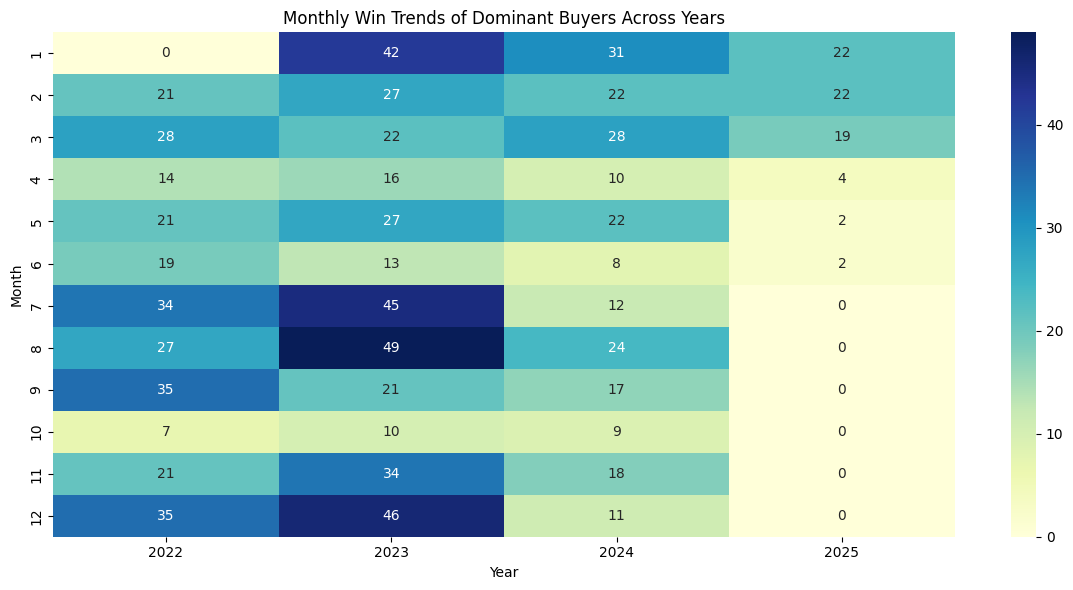

In [18]:
#Extracting yearly trends of dominant buyers
dominant_buyers = buyer_counts[buyer_counts > 100].index
df_dominant_winners = df_filtered[df_filtered['h1_buyer_name'].isin(dominant_buyers)].copy()
df_dominant_winners['month'] = df_dominant_winners['auction_date'].dt.month
df_dominant_winners['years'] = df_dominant_winners['auction_date'].dt.year

# Calculate win counts by month
mon_yr_win_counts = df_dominant_winners.groupby(['years', 'month']).size().unstack(fill_value=0)


# Plot the win counts by month
plt.figure(figsize=(12, 6))
sns.heatmap(mon_yr_win_counts.T, cmap='YlGnBu', annot=True, fmt='d')
plt.title('Monthly Win Trends of Dominant Buyers Across Years')
plt.xlabel('Year')
plt.ylabel('Month')
plt.tight_layout()
plt.show()



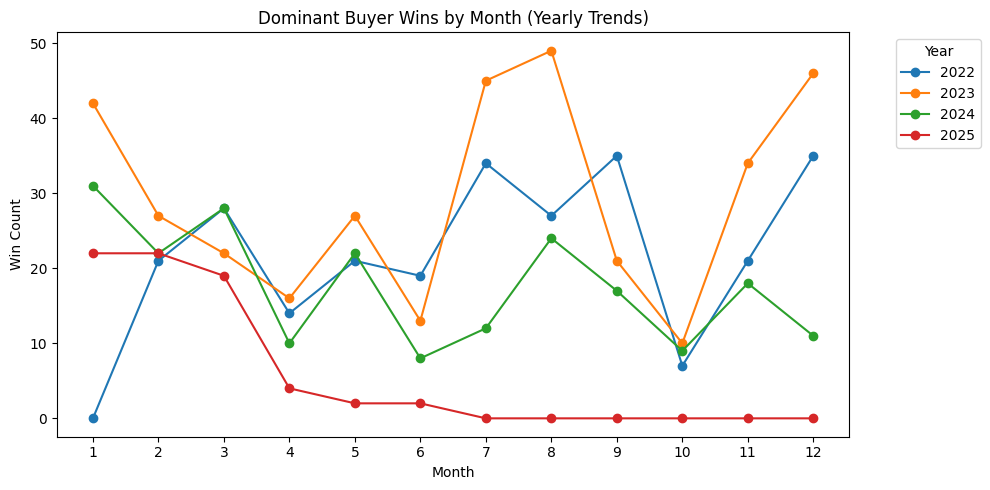

In [19]:
df_dominant_winners['year_month'] = df_dominant_winners['auction_date'].dt.to_period('M')
monthly_yearly = df_dominant_winners.groupby(['years', 'month']).size().unstack(fill_value=0)

# Plot the win counts by month
plt.figure(figsize=(10, 5))
for year in monthly_yearly.index:
    plt.plot(monthly_yearly.columns, monthly_yearly.loc[year], label=str(year), marker='o')

plt.title('Dominant Buyer Wins by Month (Yearly Trends)')
plt.xlabel('Month')
plt.ylabel('Win Count')
plt.xticks(range(1, 13))
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()



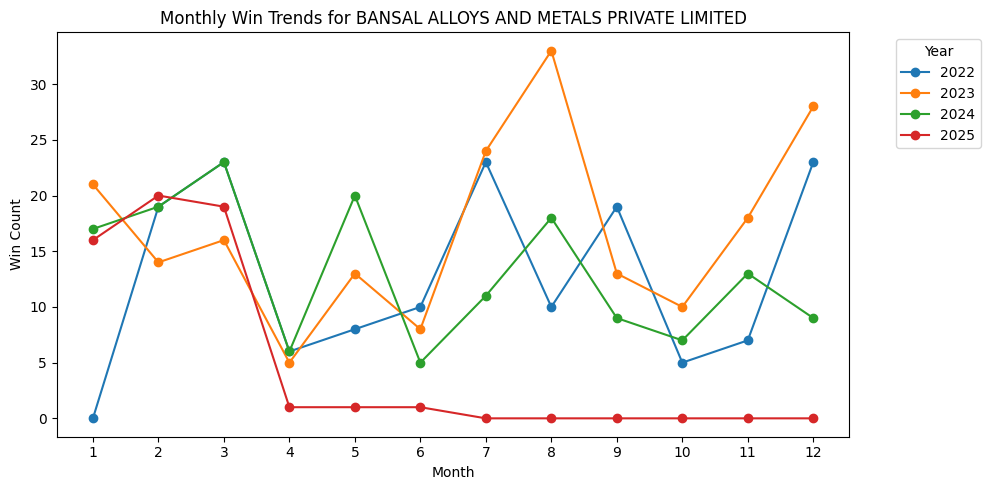

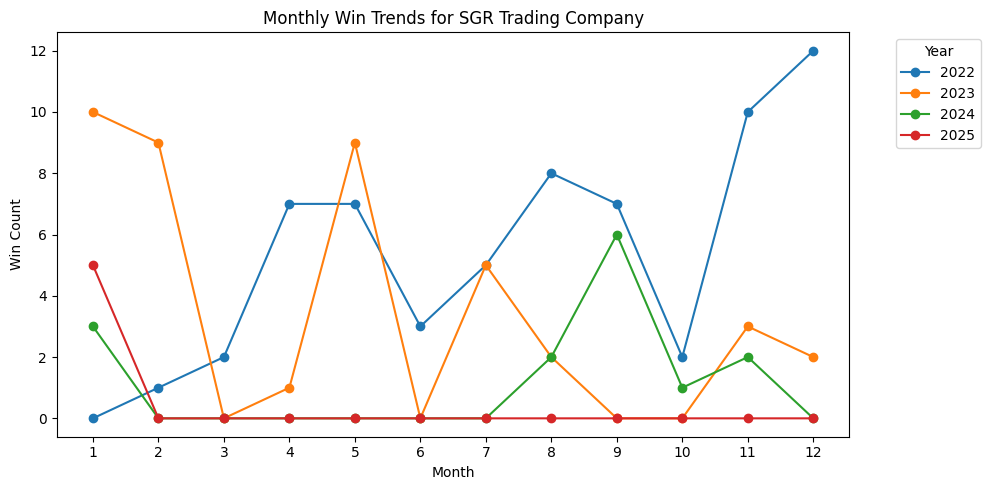

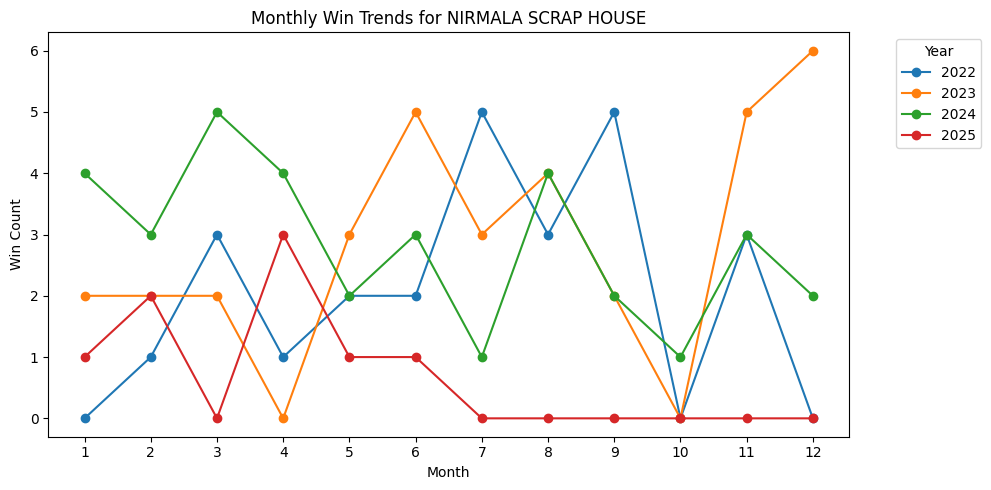

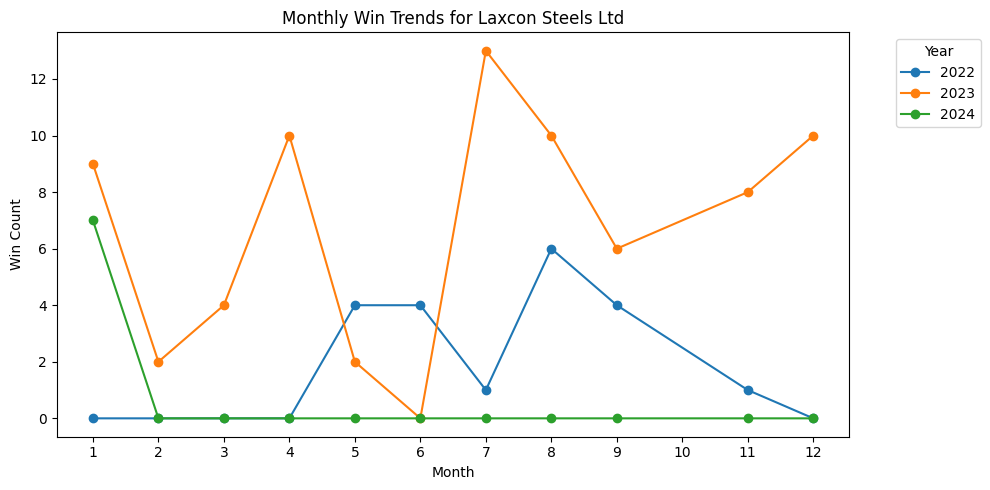

In [20]:
import matplotlib.pyplot as plt

# Step 1: Get the list of buyers with 100+ wins
dominant_buyers = buyer_counts[buyer_counts > 100].index

# Step 2: Prepare monthly count per year for each buyer
for buyer in dominant_buyers:
    df_buyer = df_dominant_winners[df_dominant_winners['h1_buyer_name'] == buyer]
    buyer_monthly = df_buyer.groupby(['years', 'month']).size().unstack(fill_value=0)

    # Step 3: Plot
    plt.figure(figsize=(10, 5))
    for year in buyer_monthly.index:
        plt.plot(buyer_monthly.columns, buyer_monthly.loc[year], label=str(year), marker='o')

    plt.title(f'Monthly Win Trends for {buyer}')
    plt.xlabel('Month')
    plt.ylabel('Win Count')
    plt.xticks(range(1, 13))
    plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

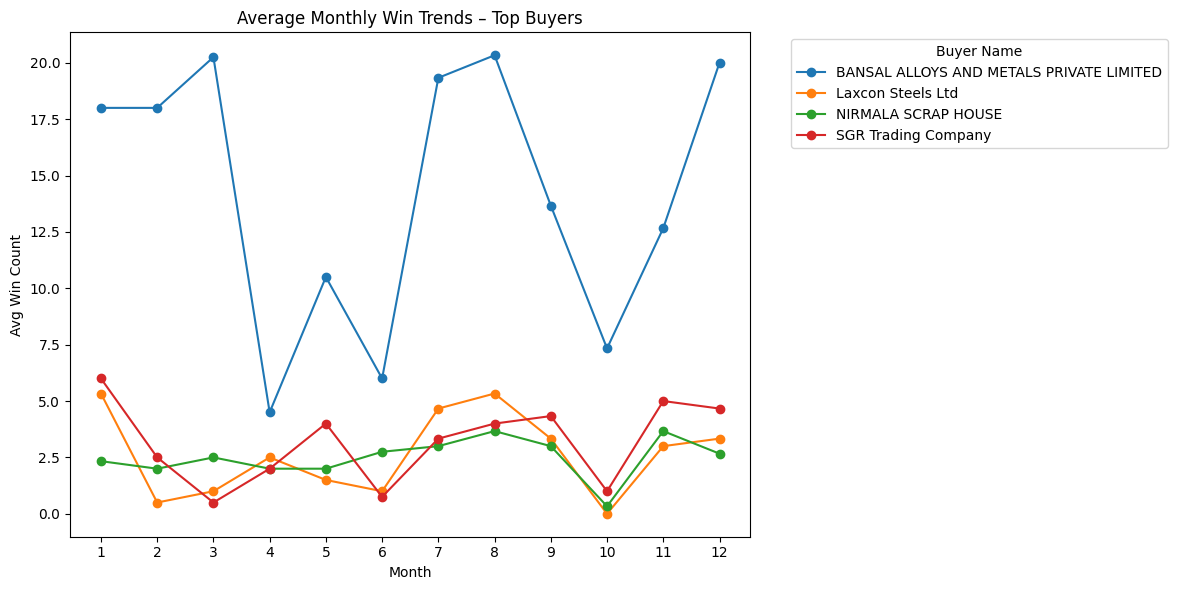

In [21]:
import matplotlib.pyplot as plt

# Step 1: Group by buyer, year, and month
buyer_monthly = df_dominant_winners.groupby(['h1_buyer_name', 'years', 'month']).size().reset_index(name='win_count')

# Step 2: Pivot to reshape for plotting
pivoted = buyer_monthly.pivot_table(index=['years', 'month'], columns='h1_buyer_name', values='win_count', fill_value=0)

# Step 3: Plot all buyers on same figure
plt.figure(figsize=(12, 6))
for buyer in pivoted.columns:
    # Aggregate across years for each buyer
    monthly_avg = pivoted[buyer].groupby(level='month').mean()
    plt.plot(monthly_avg.index, monthly_avg.values, label=buyer, marker='o')

plt.title('Average Monthly Win Trends – Top Buyers')
plt.xlabel('Month')
plt.ylabel('Avg Win Count')
plt.xticks(range(1, 13))
plt.legend(title='Buyer Name', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

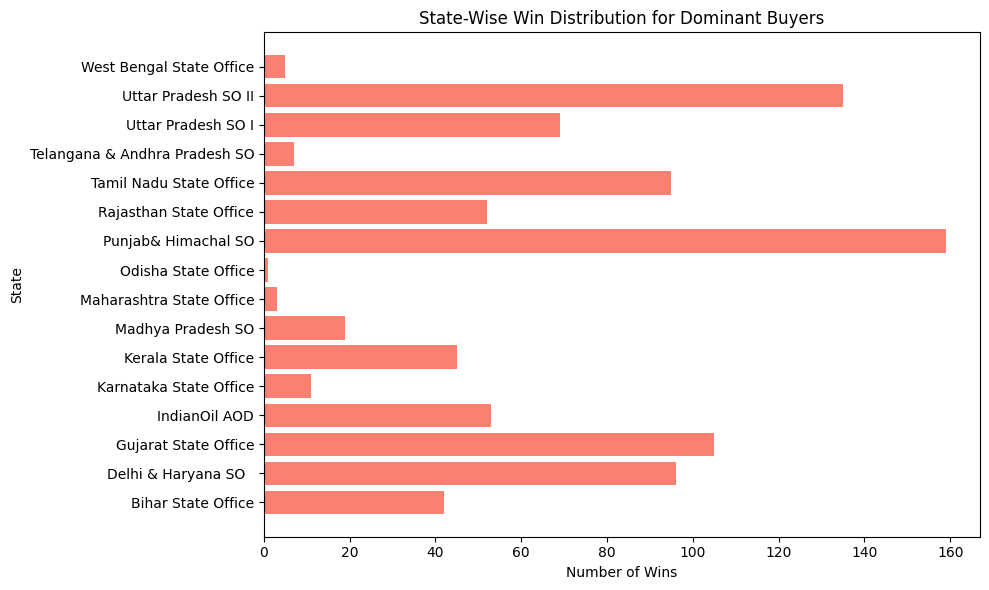

In [32]:
state_win_counts = df_dominant_winners.groupby(['state']).size().reset_index(name='win_count')


plt.figure(figsize=(10, 6))
plt.barh(state_win_counts['state'], state_win_counts['win_count'], color='salmon')
plt.title('State-Wise Win Distribution for Dominant Buyers')
plt.xlabel('Number of Wins')
plt.ylabel('State')
plt.tight_layout()
plt.show()


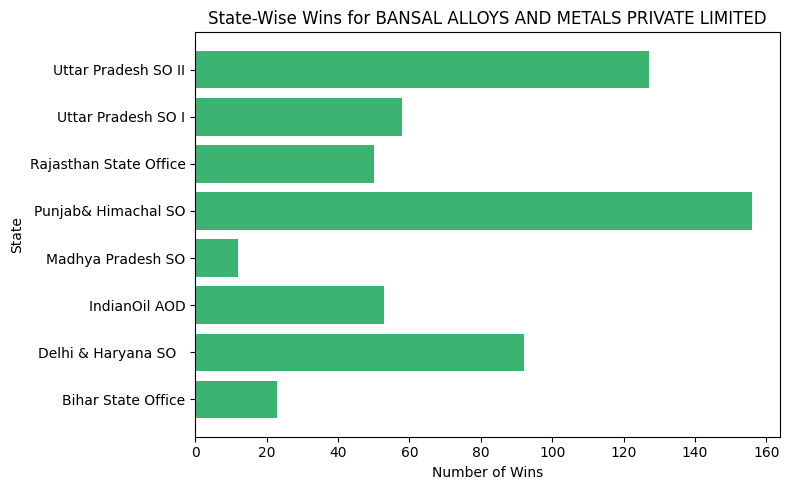

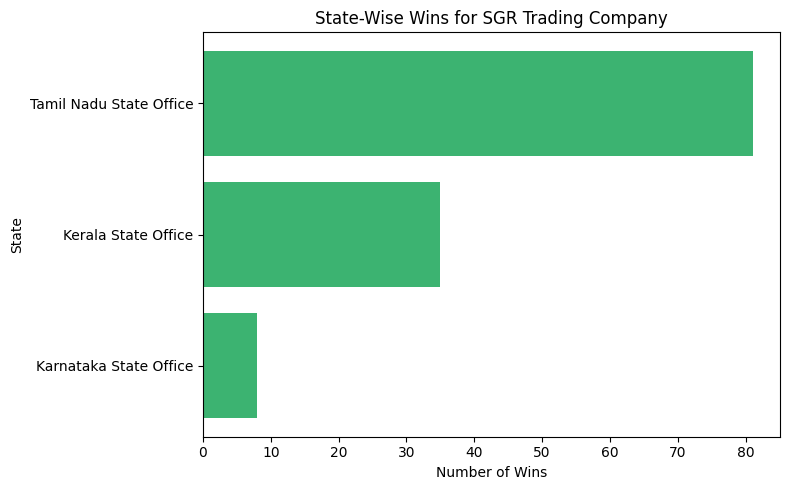

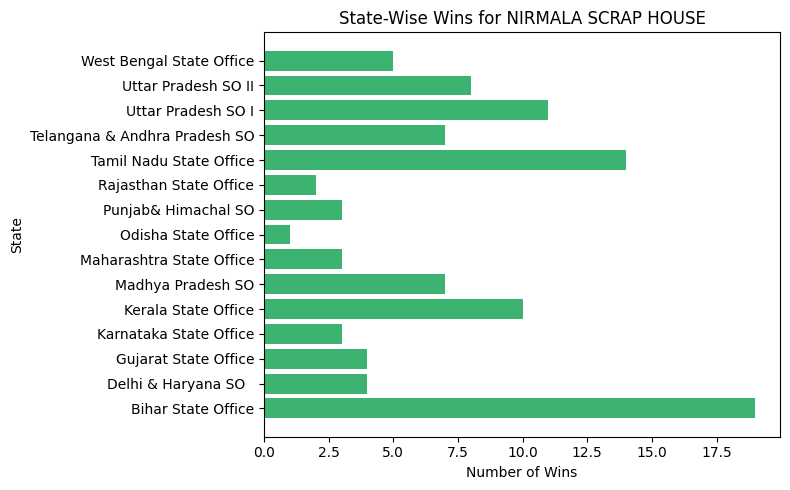

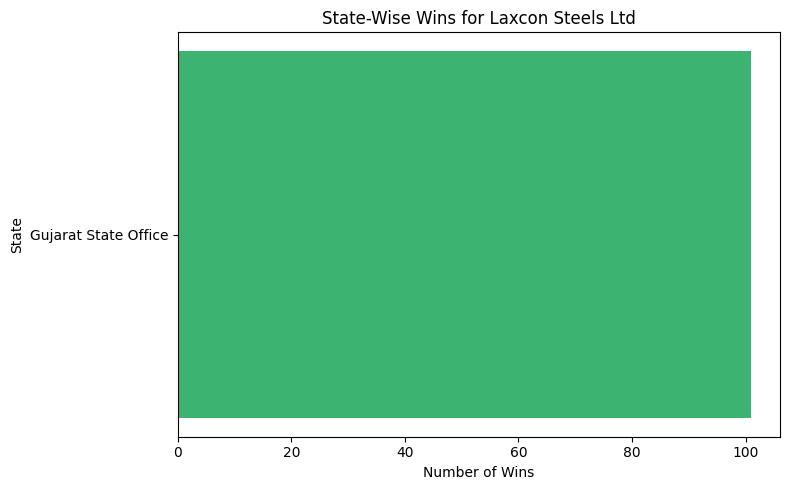

In [36]:
# Step 1: Identify top 4 dominant buyers
top4_buyers = buyer_counts.sort_values(ascending=False).head(4).index
df_top4 = df_filtered[df_filtered['h1_buyer_name'].isin(top4_buyers)].copy()

# Step 2: Extract state info from auction location
# df_top4['state'] = df_top4['state'].str.split(',').str[-1].str.strip()

# Step 3: Group by buyer and state
statewise_breakdown = df_top4.groupby(['h1_buyer_name', 'state']).size().reset_index(name='win_count')

# Step 4: Plot individual bar charts per buyer
import matplotlib.pyplot as plt

for buyer in top4_buyers:
    data = statewise_breakdown[statewise_breakdown['h1_buyer_name'] == buyer]
    plt.figure(figsize=(8, 5))
    plt.barh(data['state'], data['win_count'], color='mediumseagreen')
    plt.title(f'State-Wise Wins for {buyer}')
    plt.xlabel('Number of Wins')
    plt.ylabel('State')
    plt.tight_layout()
    plt.show()

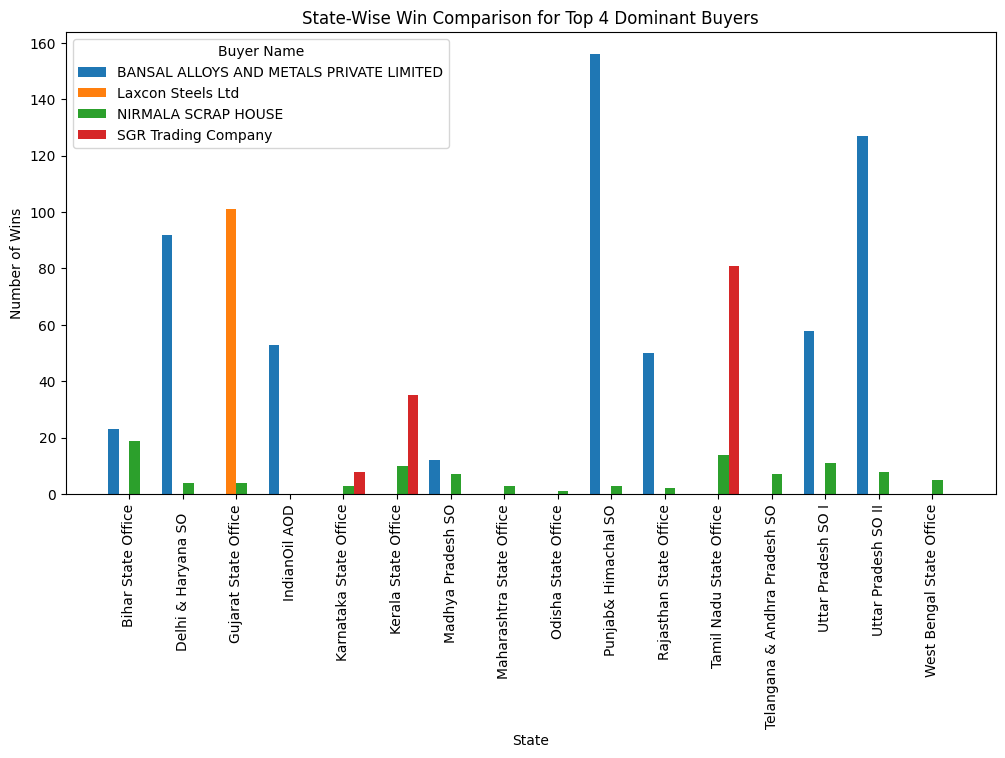

In [39]:
# Step 1: Filter top 4 dominant buyers
top4_buyers = buyer_counts.sort_values(ascending=False).head(4).index
df_top4 = df_filtered[df_filtered['h1_buyer_name'].isin(top4_buyers)].copy()

# Step 3: Count wins per buyer per state
grouped_data = df_top4.groupby(['state', 'h1_buyer_name']).size().unstack(fill_value=0)

# Step 4: Plot grouped bar chart
import matplotlib.pyplot as plt
import numpy as np

states = grouped_data.index
x = np.arange(len(states))
width = 0.2

plt.figure(figsize=(12, 6))
for i, buyer in enumerate(grouped_data.columns):
    plt.bar(x + i * width, grouped_data[buyer], width, label=buyer)

plt.xticks(x + width * 1.5, states, rotation=90)
plt.xlabel('State')
plt.ylabel('Number of Wins')
plt.title('State-Wise Win Comparison for Top 4 Dominant Buyers')
plt.legend(title='Buyer Name')

plt.show()

# MIDDLE SEGMENT

In [23]:
buyer_counts_mid = df_filtered['h1_buyer_name'].value_counts()

#Identifying buyers with mid-frequency winning

mid_freq_buyer = buyer_counts_mid[(buyer_counts_mid > 20) & (buyer_counts_mid < 100)].index

#Extracting data for mid-frequency buyers
df_mid_freq = df_filtered[df_filtered['h1_buyer_name'].isin(mid_freq_buyer)].copy()



df_mid_freq_sorted = df_mid_freq[['h1_buyer_name', 'auction_date', 'product_group']].sort_values(by='auction_date')

In [ ]:

# df_mid_freq_sorted.to_excel('../results/mid_freq_win_details.xlsx', index=False)

In [26]:

def get_avg_win_interval(df):
    intervals = []
    for buyer, group in df.groupby('h1_buyer_name'):
        dates = pd.to_datetime(group['auction_date']).sort_values()
        diffs = dates.diff().dt.days.dropna()
        avg_diff = diffs.mean() if not diffs.empty else np.nan
        intervals.append({'h1_buyer_name': buyer, 'avg_win_interval_days': avg_diff})
    return pd.DataFrame(intervals)

df_win_intervals = get_avg_win_interval(df_mid_freq)

In [28]:
df_win_intervals.head()

,h1_buyer_name,avg_win_interval_days
0,AKSHAT ENTERPRISES,40.100000
1,AMMAN-TRY SPONGE & POWER PRIVATE LIMITED,26.619048
2,AMMAR INDUSTRIAL SUPPLIERS,18.225806
3,ARPIT GRANITES PVT LTD,23.450980
4,Akhil Brothers International Uk,18.962963


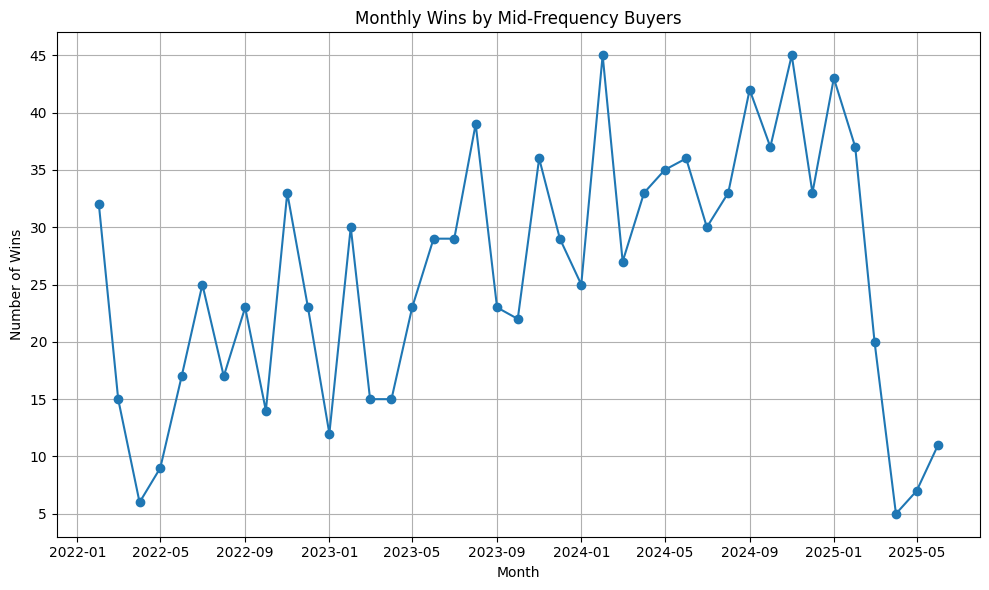

In [29]:
# Convert to month-year and count wins
df_mid_freq['auction_month'] = pd.to_datetime(df_mid_freq['auction_date']).dt.to_period('M')
monthly_win_counts = df_mid_freq.groupby('auction_month').size().reset_index(name='win_count')

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
monthly_win_counts['auction_month'] = monthly_win_counts['auction_month'].dt.to_timestamp()
plt.plot(monthly_win_counts['auction_month'], monthly_win_counts['win_count'], marker='o')
plt.title('Monthly Wins by Mid-Frequency Buyers')
plt.xlabel('Month')
plt.ylabel('Number of Wins')
plt.grid(True)
plt.tight_layout()
plt.show()

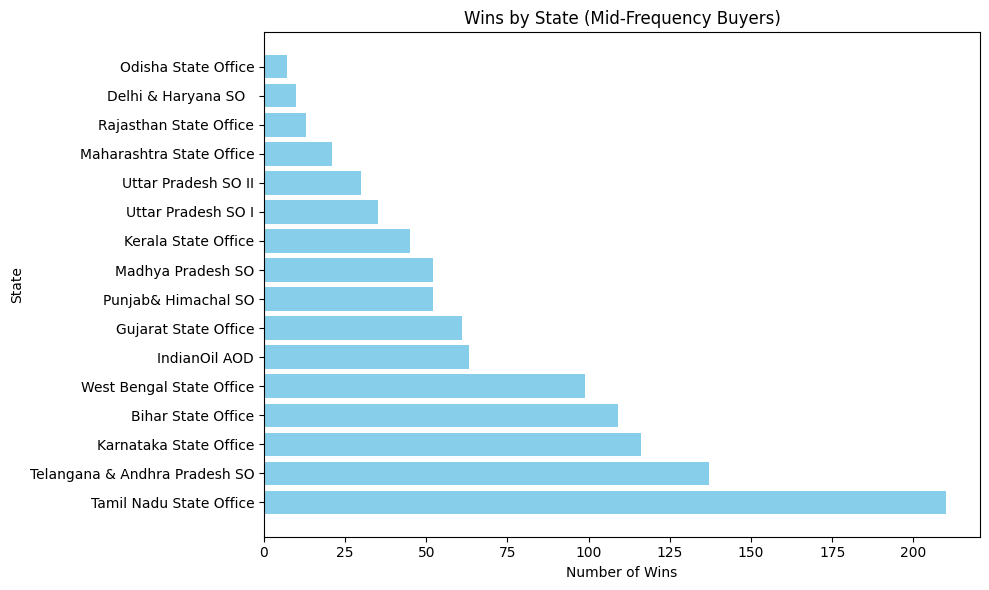

In [31]:
# Count wins by location
location_counts = df_mid_freq['state'].value_counts().reset_index()
location_counts.columns = ['state', 'win_count']

# Plot
plt.figure(figsize=(10, 6))
plt.barh(location_counts['state'], location_counts['win_count'], color='skyblue')
plt.title('Wins by State (Mid-Frequency Buyers)')
plt.xlabel('Number of Wins')
plt.ylabel('State')
plt.tight_layout()
plt.show()